In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# read data from previous example

sjodatos =pd.read_pickle("datos/SJO-pasajeros.pickle")
sjodatoscuadro = sjodatos.unstack()
sjodatoscuadro['extranjeros'].round(1)

,1,2,3,4,5,6,7,8,9,10,11,12
2011,116.3,105.4,128.9,103.1,82.7,88.0,103.3,102.9,64.6,62.6,77.5,90.3
2012,115.8,108.1,130.9,106.0,82.2,89.1,105.9,105.7,67.8,60.4,79.3,92.4
2013,122.9,109.6,133.0,108.5,85.3,95.0,110.3,112.8,70.0,67.3,83.5,107.7
2014,132.3,120.9,146.3,111.9,93.1,96.4,111.4,116.8,71.7,67.3,85.3,104.9
2015,137.2,122.7,143.8,122.8,96.5,105.1,121.5,129.9,79.6,76.4,100.5,122.6
2016,149.2,141.8,161.3,132.0,108.1,113.3,134.6,138.7,84.5,83.2,102.4,124.2
2017,153.6,145.1,179.0,148.7,119.4,126.8,141.0,142.8,97.9,90.2,117.1,135.0
2018,165.7,161.1,189.4,161.3,127.4,134.1,148.9,156.0,100.3,93.9,120.4,140.7
2019,185.3,170.4,206.7,157.0,128.2,137.0,151.4,156.4,101.2,102.0,122.1,153.3


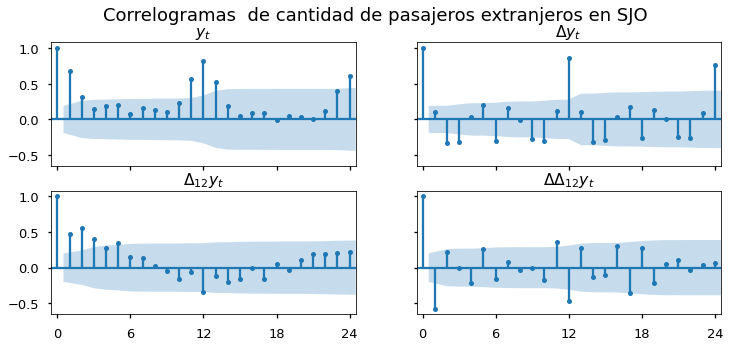

In [3]:
def correlogramas4(serie, residencia, func):
    fig, axs= plt.subplots(2,2, figsize=[12,5], sharex=True, sharey=True)
    opts = dict(lags=24)
    if func is plot_pacf:
        opts['method'] = 'ols'

    func(serie, **opts,ax=axs[0,0], title='$y_t$');
    func(serie.diff(1).dropna(), **opts, ax=axs[0,1],title='$\Delta y_t$');
    func(serie.diff(12).dropna(), **opts, ax=axs[1,0],title='$\Delta_{12}y_t$');
    func(serie.diff(1).diff(12).dropna(), **opts, ax=axs[1,1],title='$\Delta\Delta_{12}y_t$');

    for ax in axs.flat:
        ax.set(xlim=[-0.5,24.5], xticks=np.arange(0,25,6))

    pp = 'parcial' if (func is plot_pacf) else ''
    fig.suptitle(f'Correlogramas {pp} de cantidad de pasajeros {residencia} en SJO', size=18)
    return fig

extranjeros = pd.DataFrame(np.log(sjodatos['extranjeros'].values), index=pd.period_range('2011-01', '2019-12', freq='M'))
correlogramas4(extranjeros, 'extranjeros', plot_acf);

In [4]:
mod_extranjeros = SARIMAX(extranjeros, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
mod_extranjeros.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  0   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 194.101
Date:                            Tue, 23 Mar 2021   AIC                           -382.202
Time:                                    16:09:06   BIC                           -374.540
Sample:                                01-31-2011   HQIC                          -379.106
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6109      0.087     -7.024      0.000      -0.781      -0.440
ma.S.L12      -0.7632      0.117     -6.520      0.000      -0.993      -0.534
sigma2         0.0009      0.000      6.349      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.83   Prob(JB):                         0.89
Heteroskedasticity (H):               1.56   Skew:                             0.09
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

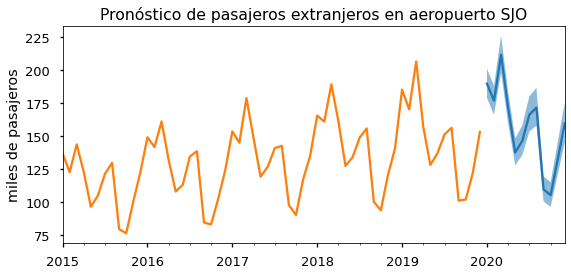

In [5]:
def plot_forecast(modelo, serie, residencia, ax):
    fcast = modelo.get_forecast('2020-12')
    ci = np.exp(fcast.conf_int())
    np.exp(fcast.predicted_mean).plot(ax=ax)
    ax.fill_between(ci.index,'lower y', 'upper y', data=ci, alpha=0.5)    
    np.exp(serie).plot(ax=ax, legend=False)
    ax.set(title=f'Pronóstico de pasajeros {residencia} en aeropuerto SJO')
    return ax

fig, ax = plt.subplots(1,1, figsize=[9,4])
plot_forecast(mod_extranjeros, extranjeros['2015':], 'extranjeros', ax)
ax.set(ylabel='miles de pasajeros');